In [ ]:
DIR = "/content/drive/MyDrive/College (Master)/Semester 3/COMP90090 - Natural Language Processing for Health/Assignment/Assignment 3/"

In [ ]:
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

# Read Data

In [ ]:
FEATURES = ["MI", "MA"]
DISORDERS = ['ppd', 'mdd', 'ocd', 'ptsd', 'adhd',
             'bipolar', 'anxiety', 'depression']
LABEL = DISORDERS + ['neg']

In [ ]:
full = []
mlabel, label = [], []

for l in LABEL:
    ea_disorder = []
    for f in FEATURES:
        df = pd.read_csv(f"{DIR}Dataset/{f}/{l}_extracted.csv", index_col=0)
        ea_disorder.append(df)
    feat = pd.concat(ea_disorder, axis=1)
    feat['mlabel'] = l
    feat['label'] = 0 if l == 'neg' else 1
    full.append(feat)

# Preprocess

In [ ]:
data = pd.concat(full, axis=0, ignore_index=True)
data.fillna(0, inplace=True)
data[data.isna().any(axis=1)]

,max_msd,mean_msd,max_md,mean_md,positive_ratio,negative_ratio,positive_combo,negative_combo,likes_count,quote_count,reply_count,retweet_count,mentioned_users,medias,mlabel,label


In [ ]:
train, test = train_test_split(data, stratify=data['mlabel'], test_size=0.2, random_state=42)

X_train = train.drop(['mlabel', 'label'], axis=1)
y_train = train['label']
my_train = train['mlabel']

X_test = test.drop(['mlabel', 'label'], axis=1)
y_test = test['label']
my_test = test['mlabel']

# Train

In [ ]:
def tune(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print('* Best hyperparameters:', grid_search.best_params_)
    print('* Best accuracy score:', grid_search.best_score_)

    return grid_search.best_estimator_

## Binary Classification

In [ ]:
nb = MultinomialNB()
svm = LinearSVC()
rf = RandomForestClassifier()
lg = LogisticRegression()
models = [lg, nb, svm, rf]

param_grids = [
    {'C': [0.001, 0.01, 0.1, 1, 10]},
    {'alpha': [0.001, 0.01, 0.1, 1, 10]},
    {'C': [0.001, 0.01, 0.1, 1, 10]},
    {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
]

bgrids = []
# Perform hyperparameter tuning for each model
for i, model in enumerate(models):
    param_grid = param_grids[i]
    print(model.__class__.__name__)

    # For common training data
    bgrids.append(tune(model, param_grid, X_train, y_train))

LogisticRegression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Best hyperparameters: {'C': 10}
* Best accuracy score: 0.7677508878266053
MultinomialNB
* Best hyperparameters: {'alpha': 0.001}
* Best accuracy score: 0.7265887647233344
LinearSVC


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


* Best hyperparameters: {'C': 0.01}
* Best accuracy score: 0.7661029961649074
RandomForestClassifier
* Best hyperparameters: {'max_depth': None, 'n_estimators': 200}
* Best accuracy score: 0.8047217544327797


## Multilabel classification

In [ ]:
nb = MultinomialNB()
svm = LinearSVC()
rf = RandomForestClassifier()
lg = LogisticRegression()
models = [lg, nb, svm, rf]

param_grids = [
    {'C': [0.001, 0.01, 0.1, 1, 10], 'multi_class': ['multinomial']},
    {'alpha': [0.001, 0.01, 0.1, 1, 10]},
    {'C': [0.001, 0.01, 0.1, 1, 10], 'multi_class': ['ovr']},
    {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
]

mgrids = []
# Perform hyperparameter tuning for each model
for i, model in enumerate(models):
    param_grid = param_grids[i]
    print(model.__class__.__name__)

    # For common training data
    mgrids.append(tune(model, param_grid, X_train, my_train))

LogisticRegression
* Best hyperparameters: {'C': 0.01, 'multi_class': 'multinomial'}
* Best accuracy score: 0.35541329879125183
MultinomialNB
* Best hyperparameters: {'alpha': 10}
* Best accuracy score: 0.2481909335635454
LinearSVC
* Best hyperparameters: {'C': 0.01, 'multi_class': 'ovr'}
* Best accuracy score: 0.3594612695691025
RandomForestClassifier
* Best hyperparameters: {'max_depth': 20, 'n_estimators': 200}
* Best accuracy score: 0.40467150463738866


# Evaluate

In [ ]:
def evaluate(y, y_pred, y_pred_proba=None):
    report = classification_report(y, y_pred)
    print('Classification Report:')
    print(report)

    if y_pred_proba is not None:
        auroc = roc_auc_score(y, y_pred_proba)
        print('AUROC:', round(auroc, 4))
    print()

    return classification_report(y, y_pred, output_dict=True)

In [77]:
breport = pd.DataFrame(columns=['P', 'R', 'F1'], index=['Logistic Regression', 'Naive Bayes', 'Support Vector Machine', 'Random Forest'])
mreport = pd.DataFrame(columns=['P', 'R', 'F1'], index=['Logistic Regression', 'Naive Bayes', 'Support Vector Machine', 'Random Forest'])

## Binary classification

In [84]:
for i, model in enumerate(bgrids):
    print("============", model.__class__.__name__, "============")
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        report = evaluate(y_test, y_pred, model.predict_proba(X_test)[::,1])
    else:
        report = evaluate(y_test, y_pred)

    breport.iloc[i,:] = [round(report['macro avg']['precision'],2), round(report['macro avg']['recall'],2), round(report['macro avg']['f1-score'],2)]

============ LogisticRegression ============
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.03      0.06      1640
           1       0.77      0.99      0.87      5339

    accuracy                           0.77      6979
   macro avg       0.69      0.51      0.47      6979
weighted avg       0.73      0.77      0.68      6979

AUROC: 0.6977

============ MultinomialNB ============
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.17      0.22      1640
           1       0.78      0.89      0.83      5339

    accuracy                           0.72      6979
   macro avg       0.55      0.53      0.53      6979
weighted avg       0.67      0.72      0.69      6979

AUROC: 0.5698

============ LinearSVC ============
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.02      0.03      1640
           1     

In [85]:
breport

,P,R,F1
Logistic Regression,0.69,0.51,0.47
Naive Bayes,0.55,0.53,0.53
Support Vector Machine,0.65,0.51,0.45
Random Forest,0.74,0.64,0.66


## Multilabel classifiction

In [ ]:
for model in mgrids:
    print("============", model.__class__.__name__, "============")
    my_pred = model.predict(X_test)
    evaluate(my_test, my_pred)

============ LogisticRegression ============
Classification Report:
              precision    recall  f1-score   support

        adhd       0.34      0.48      0.40      1619
     anxiety       0.30      0.09      0.13       968
     bipolar       0.00      0.00      0.00       330
  depression       0.40      0.31      0.35      1360
         mdd       0.00      0.00      0.00        65
         neg       0.34      0.69      0.46      1640
         ocd       0.00      0.00      0.00       265
         ppd       0.00      0.00      0.00        49
        ptsd       0.00      0.00      0.00       683

    accuracy                           0.35      6979
   macro avg       0.15      0.18      0.15      6979
weighted avg       0.28      0.35      0.29      6979

Accuracy: 0.3478

============ MultinomialNB ============
Classification Report:
              precision    recall  f1-score   support

        adhd       0.27      0.28      0.28      1619
     anxiety       0.17      0.31    

[Text(0, 0.5, 'ppd'),
 Text(0, 1.5, 'mdd'),
 Text(0, 2.5, 'ocd'),
 Text(0, 3.5, 'ptsd'),
 Text(0, 4.5, 'adhd'),
 Text(0, 5.5, 'bipolar'),
 Text(0, 6.5, 'anxiety'),
 Text(0, 7.5, 'depression'),
 Text(0, 8.5, 'neg')]

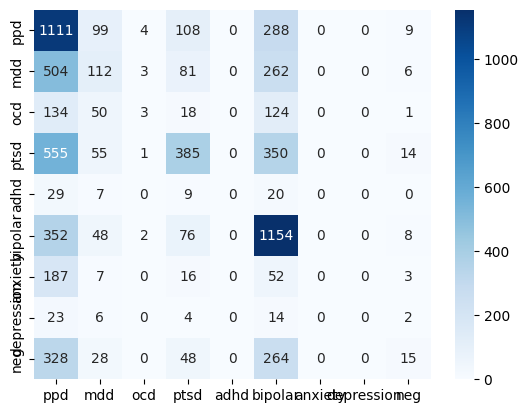

In [ ]:
# Show confustion matrix for highest accuracy score
classification_matrix = confusion_matrix(my_test, my_pred)
ax = sns.heatmap(classification_matrix, annot=True, cmap='Blues', fmt='d')
ax.set_xticklabels(LABEL)
ax.set_yticklabels(LABEL)